In [ ]:
pip install TurkishStemmer

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

# functions for data cleaning techniques
import re
import string

# importing packages and downloading stop words
from nltk.corpus import stopwords
import nltk

from TurkishStemmer import TurkishStemmer

import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from pprint import pprint
import sklearn


# calculating countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

# calculating tfidf
from sklearn.feature_extraction.text import TfidfTransformer


In [ ]:
cv_list_df = pd.read_excel('cv_list.xlsx')
job_ad_contents_df = pd.read_excel('job_ad_contents.xlsx')
job_ad_cv_evaluations_df = pd.read_excel('job_ad_cv_evaluation_results_simplified.xlsx')

In [ ]:
# dropping nan/s && removing the annoying '  nan'
cv_list_df = cv_list_df.dropna(subset=['ResumeAll'])
job_ad_contents_df = job_ad_contents_df.dropna(subset=['Ilan'])
job_ad_cv_evaluations_df = job_ad_cv_evaluations_df.dropna()
cv_list_df = cv_list_df[cv_list_df.ResumeAll != '   nan']

In [ ]:
cv_list_df.head(10)

,Unnamed: 0,RefNumber,Resume,Yetenekler,ResumeAll
0,0,473,- Mapco ve TurkcellGroup bünyesindeki şirketle...,"Ms Access,MS SQL Server,Mysql,Progress,AppleTa...",- Mapco ve TurkcellGroup bünyesindeki şirketle...
1,1,900,<p>Aile şirketimizde ve inşaat sektöründe paza...,NaN,<p>Aile şirketimizde ve inşaat sektöründe paza...
2,2,1323,"Bilgi İşlem Yöneticisi.&nbsp;Moda Tekstil, Rot...","Windows Server 2008,Cobol,Autodesk,Sqlite Veri...","Bilgi İşlem Yöneticisi.&nbsp;Moda Tekstil, Rot..."
3,3,3748,- Setting up departments in the production fac...,NaN,- Setting up departments in the production fac...
4,4,6363,<p>İç Satın alma faaliyetlerinden sorumlu Satı...,"SAP,Bilgisayar Ofis Programları,Trekking,Ms Of...",<p>İç Satın alma faaliyetlerinden sorumlu Satı...
5,5,6887,"• Windows 98,Windows 2000 Professional, Windo...","C,Visual Basic,Pascal,Fiber Optics,Kaynak Bilg...","• Windows 98,Windows 2000 Professional, Windo..."
6,6,7282,<div>Birkaç şirketten oluşmuş tüm şirketin IT ...,"Firebird,Mysql,Freebsd,C, C++, C# Visual , Jav...",<div>Birkaç şirketten oluşmuş tüm şirketin IT ...
7,7,8096,<p>•\tHP ürün pörtföyünde’ki sunucu ve storag...,"Analytics,Thinclient,Microsoft Visual Studio,D...",<p>•\tHP ürün pörtföyünde’ki sunucu ve storag...
8,8,8735,"MS Office (Excel, Word, Access, Power Point),...",NaN,"MS Office (Excel, Word, Access, Power Point),..."
9,9,8920,"*Tamamen ithalat, satış dağıtım yapılan şirket...","ISO 9001,ISO 9001:2000,SAP,SAP/MM,Erp Lojistik...","*Tamamen ithalat, satış dağıtım yapılan şirket..."


In [ ]:
job_ad_contents_df.head(10)

,Unnamed: 0,JobId,Ilan
0,0,1870838,Makam Şoförü \r\n<ul>\r\n<li>En az 5 yıl Makam...
1,1,1676048,Şoför / Sürücü Avrupa Bölge Müdürlüğü'ne bağlı...
2,2,2141993,Şoför / Sürücü Sitil Çizgi Şirketler Grubu bün...
3,3,2175311,Şoför / Sürücü <strong>Alfred Concierge Hizmet...
4,4,2193892,Şoför / Sürücü <ul><li><span><span>Yoğun iş te...
5,5,2089326,Aşçı <p><strong>&nbsp; &nbsp; &nbsp; AŞÇILIK E...
6,6,2189034,Aşçı Yardımcısı <h3>GENEL NİTELİKLER</h3>The H...
7,7,2005298,Akaryakıt İstasyonu Servis Elemanı Kadınların ...
8,8,2187147,Aktif Satış Yöneticisi / Yönetmeni \r\n<p><str...
9,9,2151619,"Aktif Satış Temsilcisi <blockquote type=""cite""..."


In [ ]:
cv_job_evaluations_df = job_ad_cv_evaluations_df \
                                                .merge(cv_list_df, left_on='CvId', right_on='RefNumber', how='inner') \
                                                .merge(job_ad_contents_df, left_on='JobId', right_on='JobId', how='inner')

cv_job_evaluations_df = cv_job_evaluations_df[['JobId', 'CvId', 'ResumeAll', 'Ilan', 'Label']]
cv_job_evaluations_df

,JobId,CvId,ResumeAll,Ilan,Label
0,490619,11702287,2009 senesinde Derindere Turizm firması muhase...,Yönetici Asistanı \r\n<p>Tercihen Üniversitele...,1
1,490619,100819267,Genel müdür ile diğer birim müdürleri arasında...,Yönetici Asistanı \r\n<p>Tercihen Üniversitele...,1
2,490619,105843622,"M.S Office ( Word, Excel, Power Point, ) Wind...",Yönetici Asistanı \r\n<p>Tercihen Üniversitele...,1
3,490619,106155661,"MS Office ( Word, Excel ,Power Point ) ,<p>Te...",Yönetici Asistanı \r\n<p>Tercihen Üniversitele...,1
4,490619,108241683,"Excel,Word,Mikro,POLDY... ,<p dir=""ltr"">muhas...",Yönetici Asistanı \r\n<p>Tercihen Üniversitele...,1
...,...,...,...,...,...
9550,2199387,5592918,alakart minbar servisi o da servisi kahvalti v...,Garson \r\n<ul>\r\n<li><span><span><span>&nbsp...,0
9551,2199387,6450952,"<br><p>Fine dining</p> Microsoft Selamlar, tur...",Garson \r\n<ul>\r\n<li><span><span><span>&nbsp...,0
9552,2199387,6459447,"<p dir=""ltr"">Bal&#305;k Restorant</p>\n Kişise...",Garson \r\n<ul>\r\n<li><span><span><span>&nbsp...,0
9553,2199387,6485644,"WORD,EXCEL Hizmet sektöründe, turizm işletmel...",Garson \r\n<ul>\r\n<li><span><span><span>&nbsp...,0


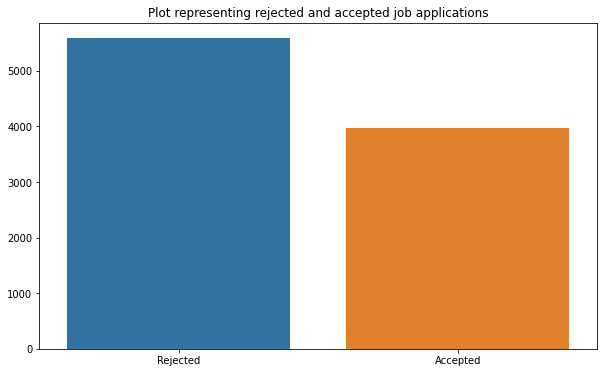

In [ ]:
x = ["Rejected" , "Accepted"]
possible_outcomes = [0, 1]
y =  [np.sum(cv_job_evaluations_df.Label == label) for label in possible_outcomes]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing rejected and accepted job applications")
sns.barplot(x, y)
plt.show()

We can see that most jobs ads have 10 applications 



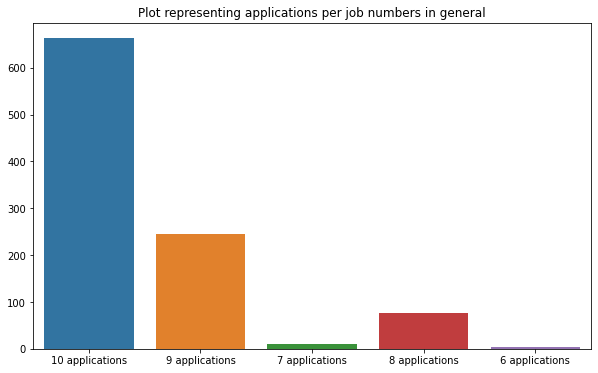

In [ ]:
# projecting number of applications groups  
job_counts = cv_job_evaluations_df.groupby('JobId').agg('CvId').size()

job_counts_df = pd.DataFrame(job_counts).reset_index()
job_counts_df.columns = ['JobId', 'count']
counts = job_counts.unique()
print('We can see that most jobs ads have 10 applications \n')
x = ["{} applications".format(count) for count in counts]
y =  [np.sum(job_counts_df['count'] == count) for count in counts]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing applications per job numbers in general")
sns.barplot(x, y)
plt.show()

## Data Cleaning

In [ ]:
# download stop words if not exist
nltk.download('stopwords')
tr_stop_words = stopwords.words('turkish')
en_stop_words = stopwords.words('english')
stop_words = [*tr_stop_words, *en_stop_words]
print(len(stop_words))

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    text = re.sub('\w*\d\w*', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words]) # removing stop words
    return text
 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
232


In [ ]:
cv_job_evaluations_df['ResumeAll'] = cv_job_evaluations_df.ResumeAll.apply(clean_text)
cv_job_evaluations_df['Ilan'] = cv_job_evaluations_df.Ilan.apply(clean_text)
cv_job_evaluations_df

,JobId,CvId,ResumeAll,Ilan,Label
0,490619,11702287,senesinde derindere turizm firması muhasebe bö...,yönetici asistanı tercihen üniversitelerin bür...,1
1,490619,100819267,genel müdür diğer birim müdürleri arasında koo...,yönetici asistanı tercihen üniversitelerin bür...,1
2,490619,105843622,office word excel power point windows vista xp...,yönetici asistanı tercihen üniversitelerin bür...,1
3,490619,106155661,ms office word excel power point tek bir bünye...,yönetici asistanı tercihen üniversitelerin bür...,1
4,490619,108241683,excel word mikro poldy muhasebe stajyeri excel...,yönetici asistanı tercihen üniversitelerin bür...,1
...,...,...,...,...,...
9550,2199387,5592918,alakart minbar servisi servisi kahvalti var po...,garson nbsp nbsp yıl otelcilik servis tecrübes...,0
9551,2199387,6450952,fine dining microsoft selamlar turizm anadolu ...,garson nbsp nbsp yıl otelcilik servis tecrübes...,0
9552,2199387,6459447,bal k restorant kişisell alacarte eservis balı...,garson nbsp nbsp yıl otelcilik servis tecrübes...,0
9553,2199387,6485644,word excel hizmet sektöründe turizm işletmeler...,garson nbsp nbsp yıl otelcilik servis tecrübes...,0


## Tokenization And Stemming

In [ ]:
# turkish stemmer object
turkishStemmer = TurkishStemmer()

# calculate and extract tokens
def tokenizer(text):
    tokenized = [w for w in text.split()]
    return tokenized

# stem and tokenize
def stemmer_tokenizer(text):
    return [turkishStemmer.stem(word) for word in text.split()]

## Count Vectorizer

In [ ]:
def count_and_vectorize():
  vectorizer = CountVectorizer(max_features=5000, tokenizer=stemmer_tokenizer, ngram_range=(1, 2))
  return vectorizer

In [ ]:
documents = cv_job_evaluations_df.ResumeAll.append(cv_job_evaluations_df.Ilan)

In [ ]:
vectorizer = count_and_vectorize()
# vectorize:fit on Resumes and Ilans documents
vectorizer.fit(documents)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=5000, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function stemmer_tokenizer at 0x7f945f5e0488>,
                vocabulary=None)

In [ ]:
# transform resumes
resmues_vectorized = vectorizer.transform(cv_job_evaluations_df.ResumeAll)

In [ ]:
# transform ilans (job ads)
job_ads_vectorized = vectorizer.transform(cv_job_evaluations_df.Ilan)

In [ ]:
print(vectorizer.vocabulary_)

In [ ]:
# Random Forest Classifier for CountVects

RANDOM_STATE=42
CV=5

X = np.concatenate([resmues_vectorized.toarray(), job_ads_vectorized.toarray()], axis=1)
y = cv_job_evaluations_df.Label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
rfc = RandomForestClassifier(n_estimators=500, verbose=1, n_jobs=-1, criterion="entropy", random_state=42)
rfc.fit(X_train, y_train)
accuracies = cross_val_score(rfc, X, y, scoring='accuracy', cv=CV)

print('#' * 30)
print(accuracies)
print('#' * 30)
predictions = rfc.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))
print('#' * 30)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   37.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finis

##############################
[0.75196232 0.7566719  0.76295133 0.75981162 0.73835688]
##############################


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


[[952 168]
 [337 454]]
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      1120
           1       0.73      0.57      0.64       791

    accuracy                           0.74      1911
   macro avg       0.73      0.71      0.72      1911
weighted avg       0.73      0.74      0.73      1911

0.7357404500261643
##############################


[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


## Term-Frequency, Inverse-Document Frequency

In [ ]:
def tf_idf_vectorizer():
  tf_idf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
  return tf_idf_transformer

In [ ]:
# tf_idf-vecs for resumes and job ads

tf_idf_transformer = tf_idf_vectorizer()
tf_idf_transformer.fit(X)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [ ]:
X_transformed = tf_idf_transformer.transform(X)

In [ ]:
X_transformed.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Random Forest Classifier for TF-IDF Vectors

RANDOM_STATE=42
CV=5

y = cv_job_evaluations_df.Label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
rfc = RandomForestClassifier(n_estimators=500, verbose=1, n_jobs=-1, criterion="entropy", random_state=42)
rfc.fit(X_train, y_train)
accuracies = cross_val_score(rfc, X, y, scoring='accuracy', cv=CV)

print('#' * 30)
print(accuracies)
print('#' * 30)
predictions = rfc.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test,predictions))
print('#' * 30)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finis

##############################
[0.75196232 0.7566719  0.76295133 0.75981162 0.73835688]
##############################


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


[[952 168]
 [337 454]]
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      1120
           1       0.73      0.57      0.64       791

    accuracy                           0.74      1911
   macro avg       0.73      0.71      0.72      1911
weighted avg       0.73      0.74      0.73      1911

0.7357404500261643
##############################


[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


# Resources


1.   https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
2.   https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.XyMvm5YzY2w

3. Scikit-Learn's official website

